In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from collections import defaultdict 
from scipy import stats
from datetime import timedelta

pd.set_option('display.max_rows', None)
smartphone_dataset = pd.read_csv("/Users/simonecolombo/Desktop/VU_Amsterdam_AI_2020_2021/DM/Mood Predictor/data/dataset_mood_smartphone.csv")
smartphone_dataset.tail(10)

,Unnamed: 0,id,time,variable,value
376902,2769196,AS14.30,2014-04-06 11:24:23.055,appCat.weather,41.881
376903,2769197,AS14.30,2014-04-06 11:38:32.033,appCat.weather,4.117
376904,2769509,AS14.30,2014-04-07 18:13:31.111,appCat.weather,11.039
376905,2769513,AS14.30,2014-04-07 18:16:49.107,appCat.weather,60.829
376906,2769514,AS14.30,2014-04-07 18:21:04.197,appCat.weather,3.018
376907,2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
376908,2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
376909,2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
376910,2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033
376911,2784435,AS14.32,2014-04-07 18:25:14.036,appCat.weather,22.431


### Instance-based dataset


In [34]:
def generate_weights(array):
    weights = [len(array)/(len(array)*10) for i in range(len(array))]
    weights[0] = weights[0] * len(array)
    weights[-1] = weights[-1] * len(array)
    weights = [weight/np.sum(weights) for weight in weights]
    return weights

smartphone_dataset['time'] = pd.to_datetime(smartphone_dataset['time']).apply(lambda x: x.date())

column_names =  [variable for variable in smartphone_dataset.variable.drop_duplicates()]
column_names.append('target_mood')
column_names.append('id')


# Create empty the instance_based_dataset with as columns the observed variables, the user's ID and the target mood
instance_based_dataset = pd.DataFrame(columns=column_names)

window_size = 5
window_values = []
grouped_df =  smartphone_dataset.groupby(['id'])

for id, rows in grouped_df:
    min_date, max_date =  grouped_df.get_group(id).time.min(),  grouped_df.get_group(id).time.max()
    index_dates = np.arange(min_date, max_date, 1) 
    for idx in range(len(index_dates)-window_size):
        value_dict = defaultdict(list, { k:[] for k in column_names})
        data = rows.loc[(grouped_df.get_group(id).time >= index_dates[idx]) & (grouped_df.get_group(id).time < index_dates[idx+window_size])]
        start =  index_dates[idx]            
        end =   index_dates[idx+window_size] 
        for index, row in data.iterrows():           
            value_dict[row['variable']].append(row['value'])
        
        # Aggregate values in each window
        for key, value in value_dict.items():
            if value:
                if key == 'call' or  key == 'sms':
                    value_dict[key] = np.sum(value)
                elif ('appCat' in key) or key == 'screen':  
                    value_dict[key] =  np.average(sorted(value), weights = generate_weights(sorted(value)))
                elif key == 'mood':
                    value_dict[key] = np.median(value)
                else: 
                    value_dict[key] = np.mean(value)
            else: # if the user did not record any value for that variable, that is set to 0.0
                if ('appCat' in key) or key == 'screen' or key == 'call' or key == 'sms' or key == 'activity':
                    value_dict[key] = 0
                else: 
                    value_dict[key] = np.nan

       
        if ((grouped_df.get_group(id).variable == 'mood') & (grouped_df.get_group(id).time == ((pd.to_datetime(index_dates[idx+1]) + timedelta(days=1)).date()))).any():
             target_mood =  rows.loc[(grouped_df.get_group(id).variable == 'mood') & (grouped_df.get_group(id).time == ((pd.to_datetime(index_dates[idx+1]) + timedelta(days=1)).date()))]['value'].mean() 
        else:
             target_mood = np.nan
        value_dict['target_mood'] = target_mood
        value_dict['id'] = id
        value_dict['days_range'] = str(start) 
        instance_based_dataset = instance_based_dataset.append(value_dict, ignore_index = True)

instance_based_dataset.tail(100)

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,...,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,target_mood,id,days_range
1892,6.857143,-0.904762,0.190476,0.097598,250.408768,38.0,2.0,443.002036,246.329295,361.147345,...,6.036,47.375482,405.178316,48.437669,0,0,0,7.750000,AS14.32,2014-05-07
1893,7.090909,-0.818182,0.272727,0.105998,250.751843,34.0,2.0,442.972033,246.866755,361.470478,...,6.036,48.06463,421.830313,48.25195,0,0,0,7.250000,AS14.32,2014-05-08
1894,NaN,NaN,NaN,0,0,33.0,3.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-17
1895,NaN,NaN,NaN,0,0,21.0,3.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-18
1896,NaN,NaN,NaN,0,0,16.0,3.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-19
1897,NaN,NaN,NaN,0,0,13.0,2.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-20
1898,NaN,NaN,NaN,0,0,10.0,3.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-21
1899,NaN,NaN,NaN,0,0,10.0,1.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-22
1900,NaN,NaN,NaN,0,0,19.0,2.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-23
1901,NaN,NaN,NaN,0,0,22.0,2.0,0,0,0,...,0,0,0,0,0,0,0,NaN,AS14.33,2014-02-24


### Exploratory Data Analysis

<AxesSubplot:title={'center':'Histogram of Features'}>

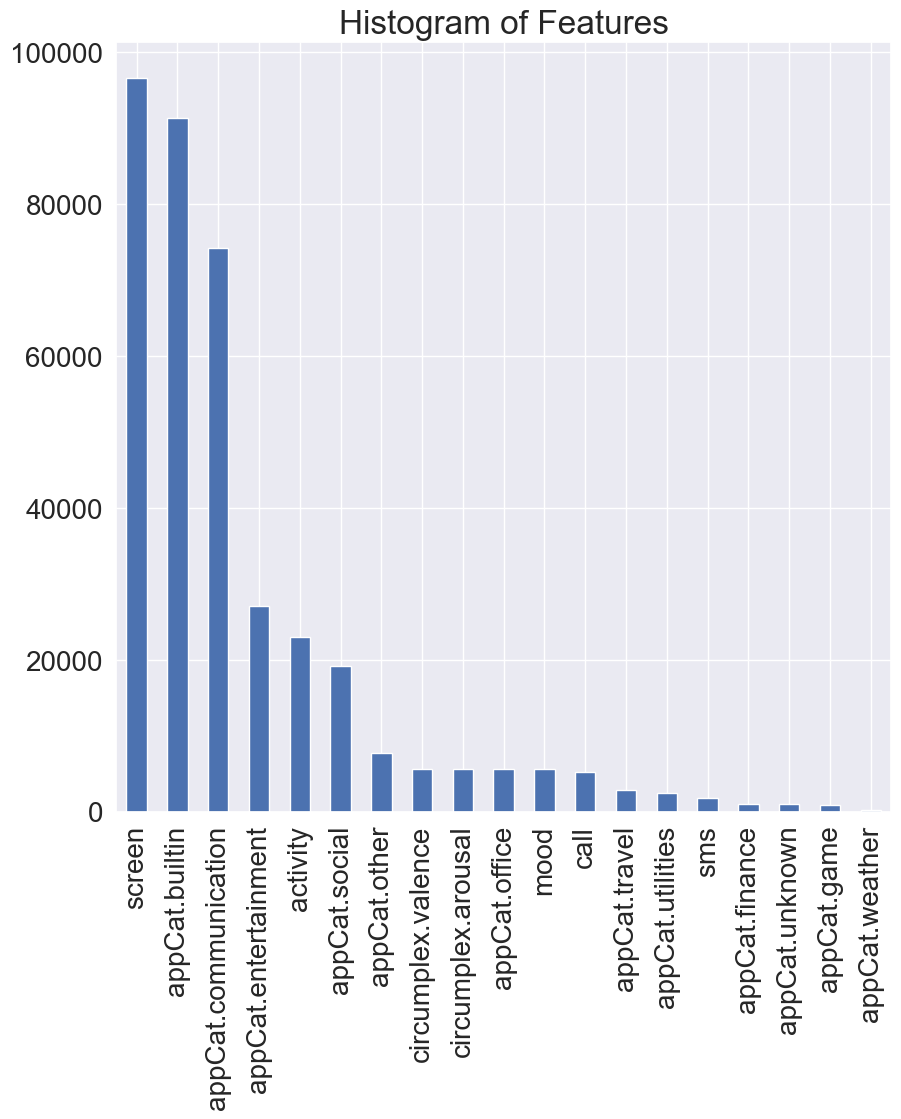

In [37]:
#Frequency plot
smartphone_dataset['variable'].value_counts().plot.bar(title="Histogram of Features", figsize=(10,10), fontsize =20)

In [38]:
# Number of users
number_users = instance_based_dataset.id.unique()
print(len(number_users))

#Percentage of null values
perc_null = instance_based_dataset.isnull().sum() / instance_based_dataset.shape[0] * 100
print(perc_null)

27
mood                    36.746988
circumplex.arousal      45.532129
circumplex.valence      51.355422
activity                 0.000000
screen                   0.000000
call                     0.000000
sms                      0.000000
appCat.builtin           0.000000
appCat.communication     0.000000
appCat.entertainment     0.000000
appCat.finance           0.000000
appCat.game              0.000000
appCat.office            0.000000
appCat.other             0.000000
appCat.social            0.000000
appCat.travel            0.000000
appCat.unknown           0.000000
appCat.utilities         0.000000
appCat.weather           0.000000
target_mood             40.863454
id                       0.000000
days_range               0.000000
dtype: float64


In [39]:
# Column types
print(instance_based_dataset.dtypes)


mood                    float64
circumplex.arousal      float64
circumplex.valence      float64
activity                 object
screen                   object
call                    float64
sms                     float64
appCat.builtin           object
appCat.communication     object
appCat.entertainment     object
appCat.finance           object
appCat.game              object
appCat.office            object
appCat.other             object
appCat.social            object
appCat.travel            object
appCat.unknown           object
appCat.utilities         object
appCat.weather           object
target_mood             float64
id                       object
days_range               object
dtype: object


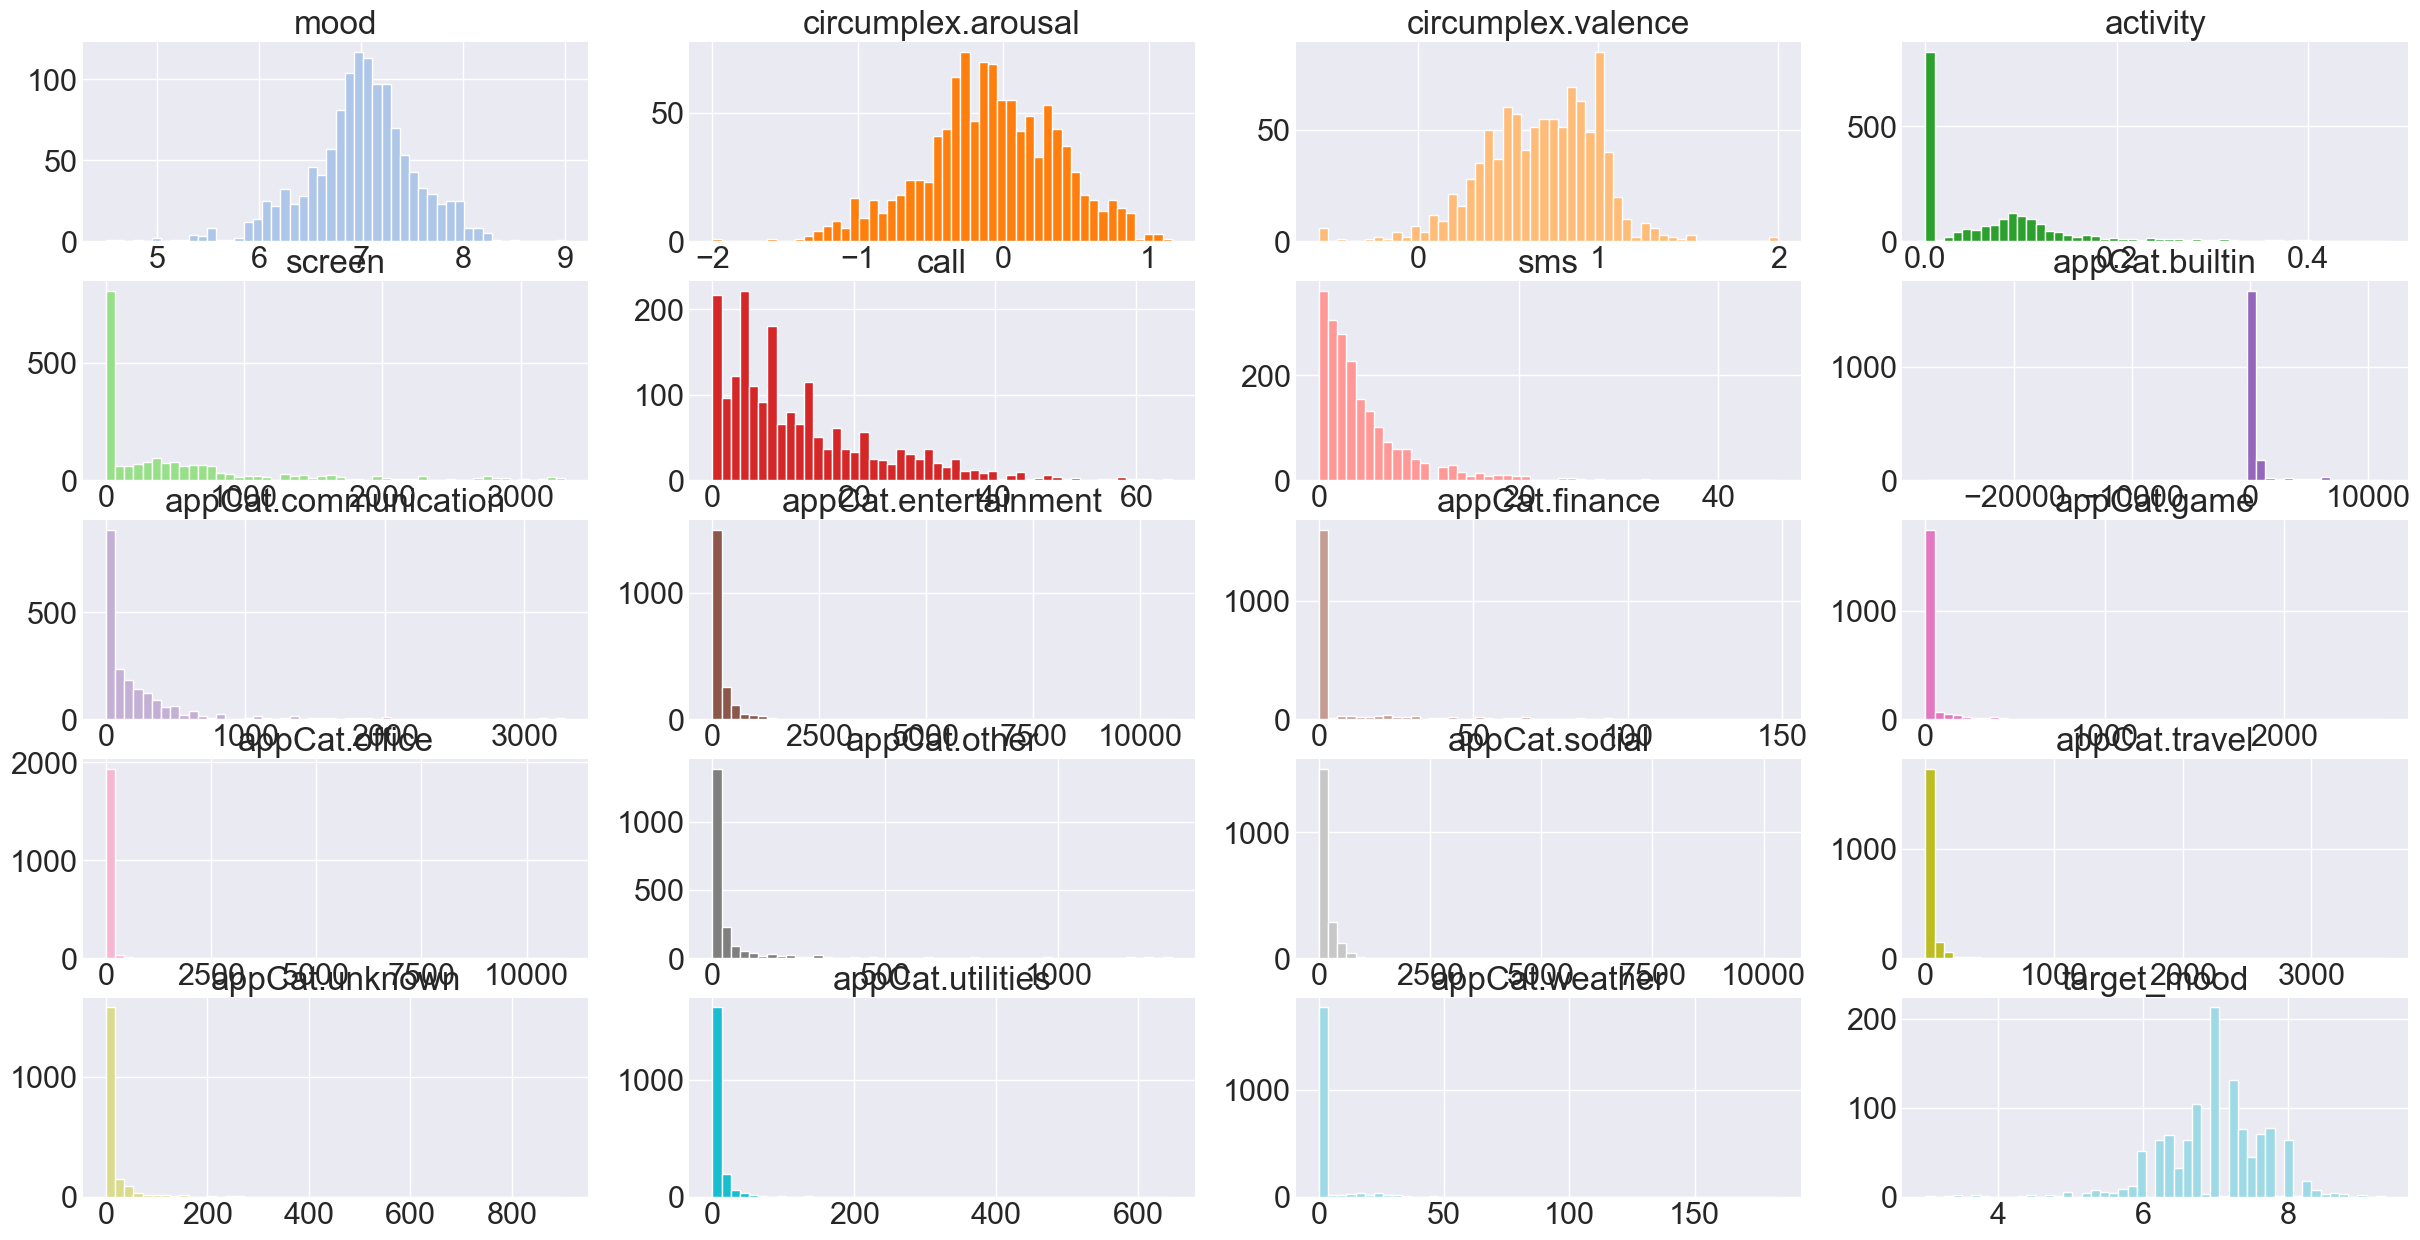

In [40]:
instance_based_dataset_cleaned =  instance_based_dataset.copy()

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')

num=0
f= plt.figure(figsize=(30,15))
for var in list(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].columns.array):
    num+=1
    ax = f.add_subplot(5,4,num)
    a = np.asarray(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]][var])
    ax.hist(a, bins=50, color=palette(num))
    ax.set_title(var)

In [168]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')

f = plt.figure(figsize=(20,30))
num=0
for i in list(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].index.levels[0]):

    ax = f.add_subplot(9,3, num)
    ax.set_title(i)
    ax.plot(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].loc[i,'mood'], marker='', color=palette(num), linewidth=2.8, alpha=0.9, label=i)
    num+=1

AttributeError: 'Int64Index' object has no attribute 'levels'

<Figure size 2000x3000 with 0 Axes>

### Data Cleaning


In [41]:
#Data type transformation
instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]] = instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].astype(float)
#Removing the rows where either mood or target mood is equal to zero
instance_based_dataset_cleaned = instance_based_dataset_cleaned.dropna(subset=['target_mood', 'mood'])
#Filling the nan values with the column mean
instance_based_dataset_cleaned = instance_based_dataset_cleaned.fillna(instance_based_dataset_cleaned.mean())


/var/folders/fx/6gj1x9190kn8blh8bw_hx5180000gn/T/ipykernel_56000/4215174421.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  instance_based_dataset_cleaned = instance_based_dataset_cleaned.fillna(instance_based_dataset_cleaned.mean())


In [42]:
instance_based_dataset_cleaned.head()

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,...,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,target_mood,id,days_range
7,6.285714,-0.142857,0.571429,0.000000,0.000000,8.0,2.0,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,6.250000,AS14.01,2014-02-24
8,6.285714,-0.142857,0.571429,0.000000,0.000000,8.0,3.0,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,6.333333,AS14.01,2014-02-25
30,6.466667,0.333333,0.685326,0.163883,686.532368,11.0,1.0,173.003042,273.250637,91.432295,...,56.0080,42.611254,219.906319,163.737425,45.173000,97.925106,30.386,6.200000,AS14.01,2014-03-19
31,6.350000,0.450000,0.685326,0.138406,684.744535,20.0,1.0,172.421646,321.516365,218.120259,...,49.7584,42.176800,226.264977,165.817982,45.173000,99.280420,30.386,6.400000,AS14.01,2014-03-20
32,6.416667,0.458333,0.685326,0.130102,1174.228167,19.0,2.0,172.516316,502.932910,217.785470,...,49.7584,43.589258,226.190245,165.817982,60.544682,99.252105,30.386,6.800000,AS14.01,2014-03-21


In [43]:

instance_based_dataset_cleaned.insert(len(instance_based_dataset_cleaned.columns.values.tolist()[:-2]) - 1, 'professional_use',  instance_based_dataset_cleaned[['appCat.office', 'appCat.finance']].sum(axis=1))
instance_based_dataset_cleaned.insert(len(instance_based_dataset_cleaned.columns.values.tolist()[:-2]) - 2,'recreational_use', instance_based_dataset_cleaned[['appCat.game','appCat.entertainment','appCat.social']].sum(axis=1))
instance_based_dataset_cleaned.insert(len(instance_based_dataset_cleaned.columns.values.tolist()[:-2]) - 3,'daily_use', instance_based_dataset_cleaned[['appCat.travel','appCat.utilities','appCat.weather']].sum(axis=1))
instance_based_dataset_cleaned.insert(len(instance_based_dataset_cleaned.columns.values.tolist()[:-2]) - 4,'other_use', instance_based_dataset_cleaned[['appCat.other','appCat.unknown']].sum(axis=1))
column_names = ['appCat.entertainment','appCat.finance','appCat.game','appCat.office','appCat.social', 'appCat.other','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
instance_based_dataset_cleaned = instance_based_dataset_cleaned.drop(columns=column_names, axis=1)

#Removing outliers 
instance_based_dataset_cleaned = instance_based_dataset_cleaned[(np.abs(stats.zscore(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]])) < 3).all(axis=1)]
#Normalizing data
instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]]  = (instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]]-instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].min())/(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].max()-instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].min())

### Data Exploration


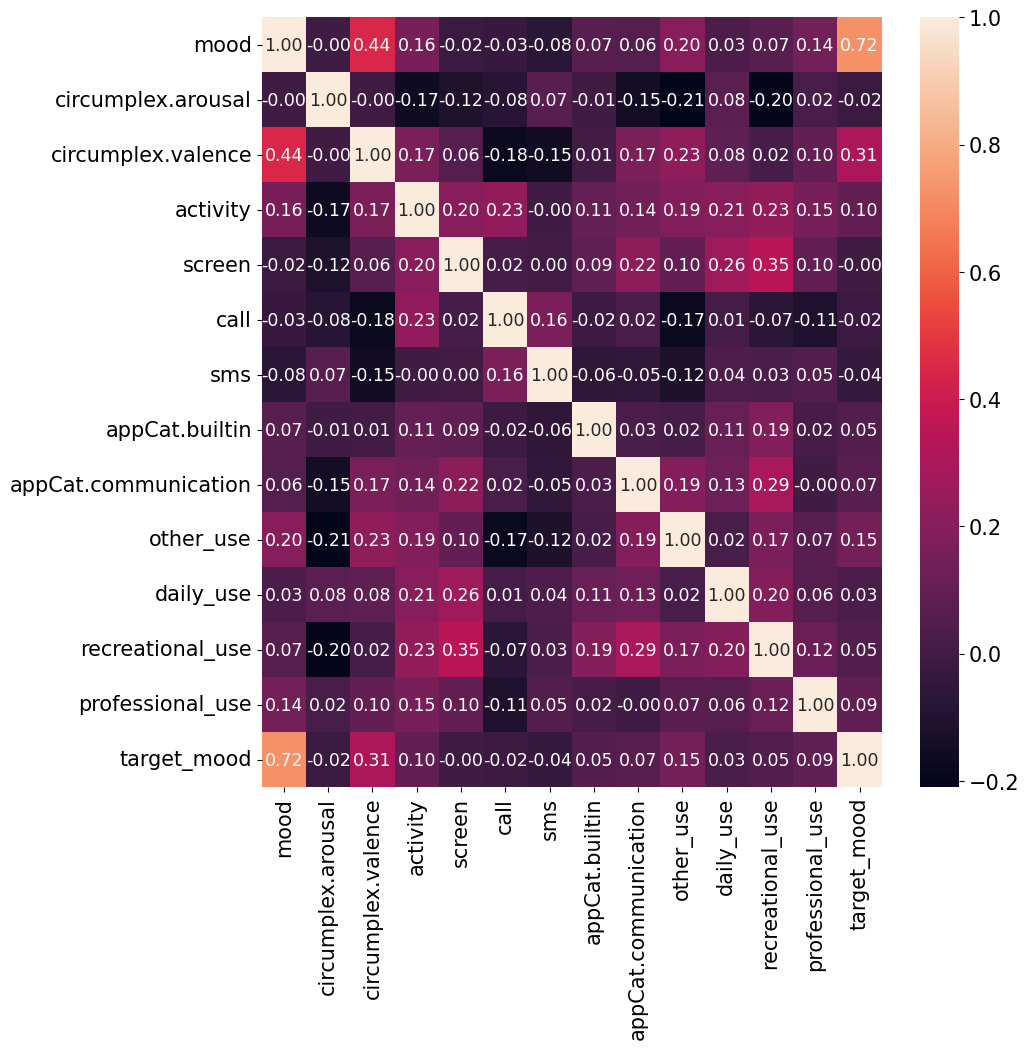

In [44]:
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(figsize=(10,10))
correlations = instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].corr()
sns.heatmap(correlations, annot = True, ax = ax, fmt='.2f', annot_kws={"fontsize":12.5})
ax.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

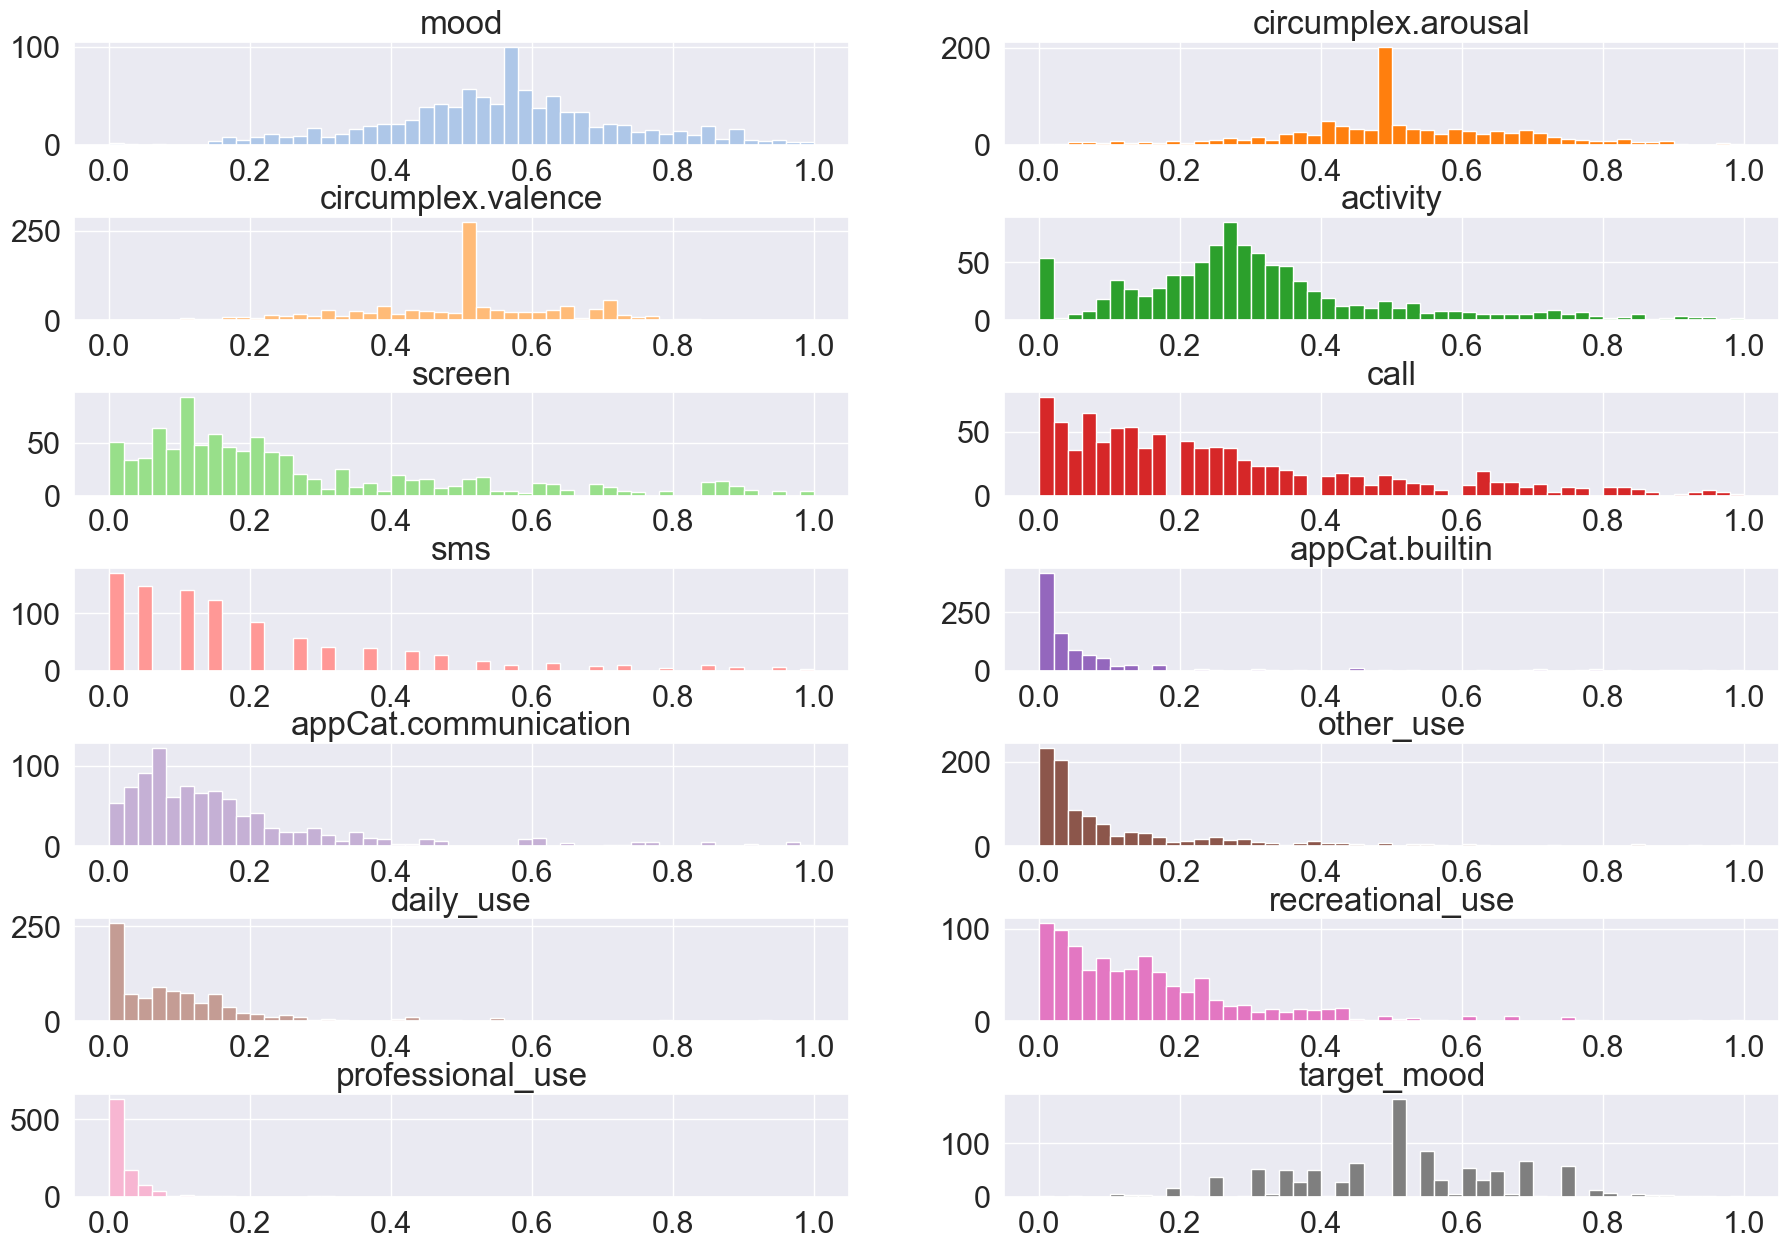

In [45]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')

sns.set(font_scale=2)
num=0
f= plt.figure(figsize=(22,15))
for var in list(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]].columns.array):
    num+=1
    ax = f.add_subplot(7,2,num)
    a = np.asarray(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]][var])
    ax.hist(a, bins=50, color=palette(num))
    ax.set_title(var)
    f.subplots_adjust(hspace=0.7)

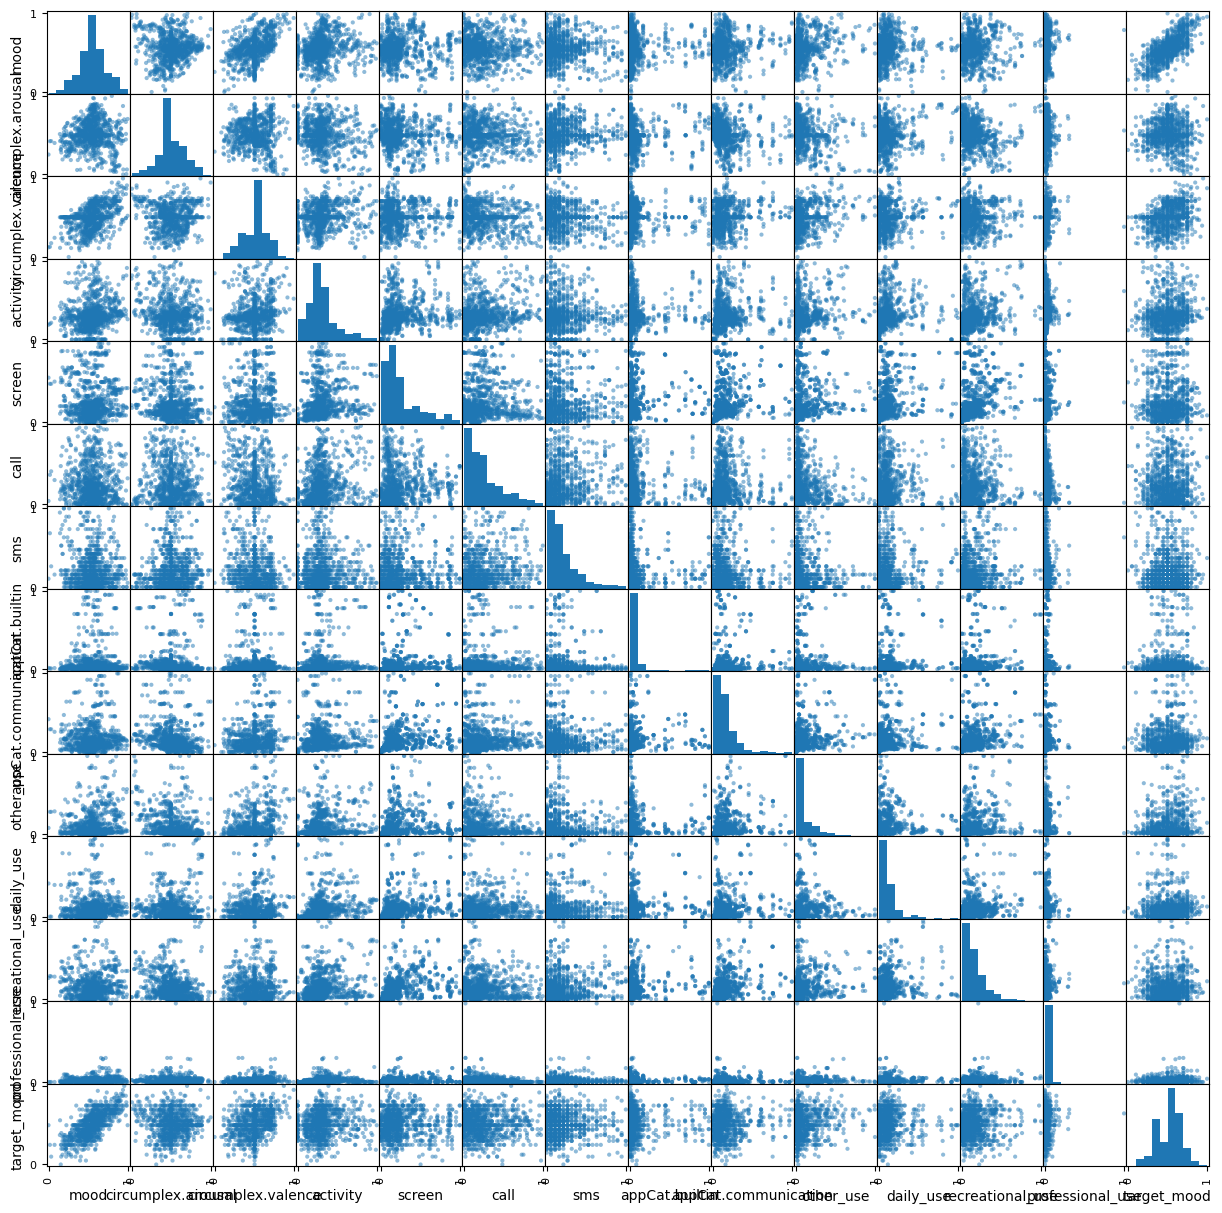

In [161]:
scatter_matrix(instance_based_dataset_cleaned[instance_based_dataset_cleaned.columns.values.tolist()[:-2]], figsize=(15, 15))
plt.show()

### Saving the datasets

In [162]:
instance_based_dataset_cleaned.to_csv('/Users/simonecolombo/Desktop/VU_Amsterdam_AI_2020_2021/DM/Mood Predictor/data/new/instance_based_dataframe_normalized_5_days_window.csv')
instance_based_dataset_cleaned.tail(100)

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,other_use,daily_use,recreational_use,professional_use,target_mood,id,days_range
1727,0.899244,0.117647,0.711845,0.486808,0.412768,0.288889,0.157895,0.096731,0.216558,0.239447,0.111261,0.448512,0.023226,0.700000,AS14.30,2014-04-28
1728,0.885139,0.101604,0.711845,0.474362,0.412021,0.311111,0.052632,0.096543,0.216686,0.238938,0.110160,0.438893,0.015194,0.800000,AS14.30,2014-04-29
1771,0.438093,0.689017,0.510338,0.555938,0.752346,0.200000,0.263158,0.012221,0.070447,0.046475,0.069960,0.027686,0.008648,0.416667,AS14.31,2014-03-31
1772,0.507417,0.735294,0.493546,0.595836,0.753097,0.288889,0.157895,0.016002,0.070581,0.045778,0.082926,0.031442,0.038988,0.400000,AS14.31,2014-04-01
1773,0.485270,0.691700,0.427107,0.579343,0.755801,0.266667,0.052632,0.016074,0.064197,0.044418,0.082750,0.031671,0.042386,0.450000,AS14.31,2014-04-02
1774,0.476071,0.695187,0.371298,0.525745,0.714830,0.266667,0.157895,0.018876,0.064474,0.046267,0.082133,0.032335,0.043377,0.600000,AS14.31,2014-04-03
1775,0.504282,0.695187,0.318907,0.493381,0.520158,0.222222,0.157895,0.021872,0.064336,0.035412,0.085363,0.032824,0.045292,0.400000,AS14.31,2014-04-04
1776,0.518388,0.679144,0.345103,0.545329,0.516558,0.200000,0.157895,0.021743,0.064499,0.035205,0.075563,0.029084,0.043845,0.400000,AS14.31,2014-04-05
1777,0.504282,0.647059,0.345103,0.518678,0.686904,0.133333,0.315789,0.021808,0.093582,0.032633,0.179185,0.026881,0.025607,0.500000,AS14.31,2014-04-06
1778,0.588917,0.695187,0.476082,0.582089,0.685282,0.333333,0.368421,0.097480,0.093855,0.032022,0.437922,0.024716,0.054666,0.500000,AS14.31,2014-04-07
